# Data Cleaning

In [4]:
import pandas as pd
dataset_path = "dataset/RISCM/"
df = pd.read_csv(dataset_path+'captions.csv')

In [ ]:
def has_duplicate_captions(row):
    captions = [row['caption_1'], row['caption_2'], row['caption_3'], row['caption_4'], row['caption_5']]
    captions = [c.strip().lower() for c in captions if isinstance(c, str)]
    return len(captions) != len(set(captions))

In [6]:
df['has_duplicate_captions'] = df.apply(has_duplicate_captions, axis=1)

duplicates_df = df[df['has_duplicate_captions']]
duplicates_df.describe()

,source,split,image,caption_1,caption_2,caption_3,caption_4,caption_5,has_duplicate_captions
count,11157,11157,11157,11157,11157,11157,11157,11157,11157
unique,3,3,11157,7656,7758,7756,7439,7014,1
top,RSICD,train,NWPU_2733.jpg,many buildings and green trees are in a dense ...,many buildings and green trees are in a dense ...,many buildings and green trees are in a dense ...,many buildings and green trees are in a dense ...,many buildings and green trees are in a dense ...,True
freq,10214,8928,1,112,102,111,121,146,11157


## Removed duplicate captions for the same image

In [7]:
def keep_unique_captions(row):
    captions = [row['caption_1'], row['caption_2'], row['caption_3'], row['caption_4'], row['caption_5']]
    normalized = {}
    for c in captions:
        if isinstance(c, str):
            key = c.strip().lower()
            if key not in normalized:
                normalized[key] = c.strip()
                
    unique_captions = list(normalized.values())
    while len(unique_captions) < 5:
        unique_captions.append('')
    row['caption_1'], row['caption_2'], row['caption_3'], row['caption_4'], row['caption_5'] = unique_captions
    return row

In [8]:
df = df.apply(keep_unique_captions, axis=1)
df = df.drop(columns=['has_duplicate_captions'])

In [9]:
df.describe()

,source,split,image,caption_1,caption_2,caption_3,caption_4,caption_5
count,44521,44521,44521,44521,44521,44521,44521,44521
unique,3,3,44521,22503,11847,11613,6913,11490
top,NWPU,train,NWPU_31430.jpg,This meadow has different sparsity in differen...,,,,
freq,31500,35614,1,130,4876,6686,8811,11157


# Extended data frame by adding captions as separate rows

In [ ]:
df_expanded = df.melt(
    id_vars=['source', 'split', 'image'],
    value_vars=['caption_1', 'caption_2', 'caption_3', 'caption_4', 'caption_5'],
    value_name='caption'
)

df_expanded = df_expanded[df_expanded['caption'].notna()]
df_expanded = df_expanded[df_expanded['caption'].str.strip() != '']

## Checked the cosine similarity scores

Cosine similarity scores of images with their captions are calculated for each row. Then, the rows with lowest similarity scores are inspected and it was seen that the captions represent the image well enough. Therefore, all the data is kept in the final data set.

In [41]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
import math
from PIL import Image
import torch

def compute_clip_similarity_batched(df, model, processor, image_folder, batch_size=32):
    similarities = []
    
    num_rows = len(df)
    num_batches = math.ceil(num_rows / batch_size)
    
    for batch_idx in range(num_batches):
        batch = df.iloc[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        
        images = []
        captions = []
        
        for _, row in batch.iterrows():
            try:
                image_path = image_folder + row["image"]
                image = Image.open(image_path).convert('RGB')
                images.append(image)
                captions.append(row['caption'])
            except Exception as e:
                print(f"Error loading {image_path}: {e}")
                images.append(None)
                captions.append(row['caption'])
        
        # Remove failed images
        valid_indices = [i for i, img in enumerate(images) if img is not None]
        if not valid_indices:
            similarities.extend([None] * len(batch))
            continue
        
        images = [images[i] for i in valid_indices]
        captions = [captions[i] for i in valid_indices]
        
        inputs = processor(text=captions, images=images, return_tensors="pt", padding=True).to('cuda')
        
        with torch.no_grad():
            outputs = model(**inputs)
            image_embeds = outputs.image_embeds  
            text_embeds = outputs.text_embeds    
        
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
        
        batch_similarities = (image_embeds * text_embeds).sum(dim=-1).tolist()
        
        batch_result = []
        j = 0
        for i in range(len(batch)):
            if i in valid_indices:
                batch_result.append(batch_similarities[j])
                j += 1
            else:
                batch_result.append(None)
        
        similarities.extend(batch_result)
    
    return similarities


In [58]:
similarity_scores = compute_clip_similarity_batched(df_expanded, model, processor,image_folder="dataset/RISCM/resized/", batch_size=32)
df_expanded['clip_cosine_similarity'] = similarity_scores

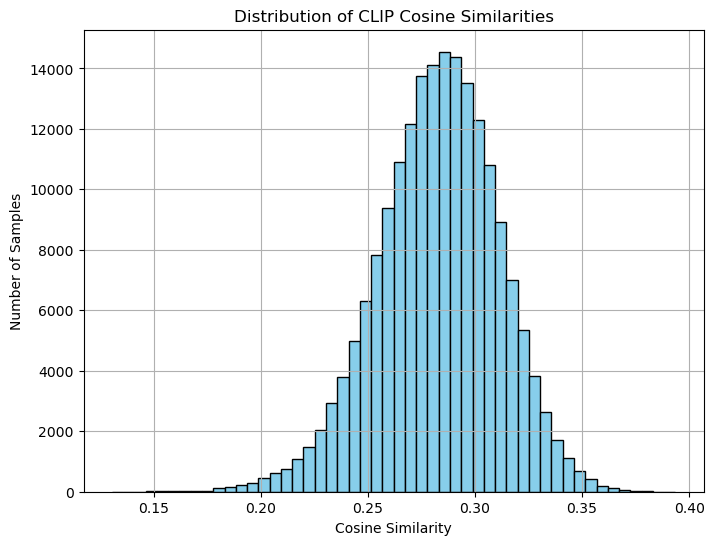

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(df_expanded['clip_cosine_similarity'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of CLIP Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()


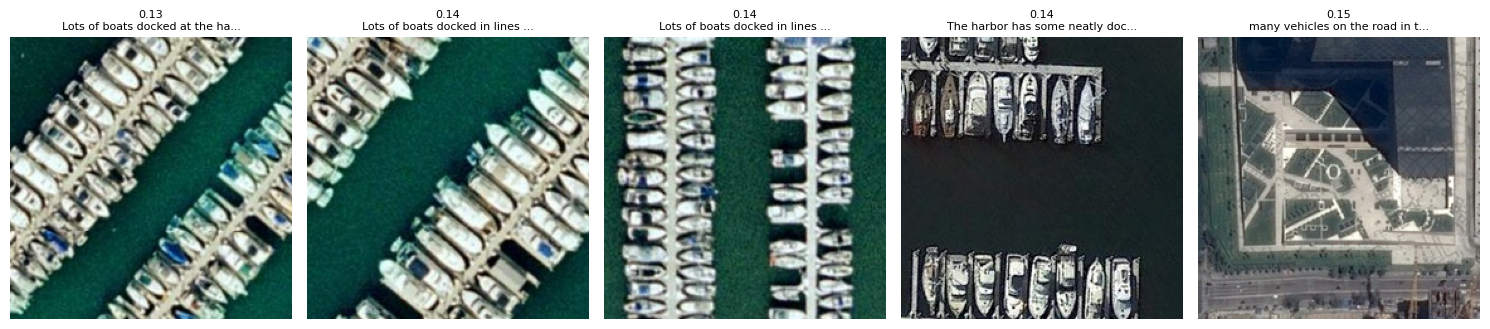

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

lowest_rows = df_expanded.nsmallest(5, 'clip_cosine_similarity')

plt.figure(figsize=(15,8))
image_folder = dataset_path + "/resized/"

for idx, (_, row) in enumerate(lowest_rows.iterrows()):
    image = Image.open(image_folder + row['image']).convert('RGB')
    
    plt.subplot(1, 5, idx + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{row['clip_cosine_similarity']:.2f}\n{row['caption'][:30]}...", fontsize=8)

plt.tight_layout()
plt.show()


## Data set is saved as different csv files depending on subset

In [79]:
df_reduced = df_expanded[['image', 'caption', 'split']]

df_reduced[df_reduced['split'] == 'train'][['image', 'caption']].to_csv('dataset/RISCM/train.csv', index=False)
df_reduced[df_reduced['split'] == 'test'][['image', 'caption']].to_csv('dataset/RISCM/test.csv', index=False)
df_reduced[df_reduced['split'] == 'val'][['image', 'caption']].to_csv('dataset/RISCM/val.csv', index=False)


In [81]:
print("Size of train set: " + str(len(pd.read_csv(dataset_path+'train.csv'))))
print("Size of val set: " + str(len(pd.read_csv(dataset_path+'val.csv'))))
print("Size of test set: " + str(len(pd.read_csv(dataset_path+'test.csv'))))

Size of train set: 151296
Size of val set: 20296
Size of test set: 19483
